## Importing and installing all the necessary packages and libraries required

In [1]:
from IPython.display import clear_output
!pip install imutils
!pip install opencv-python
import tensorflow as tf


clear_output()    #clearing the kernel screen

In [2]:
""" Importing the necessary packages and libraries """

import os 
import cv2
from tqdm import tqdm
import imutils
import shutil
import seaborn as sn  
import numpy as np    #for linear algebra
import pandas as pd   #data processing 
import matplotlib.pyplot as plt     #plotting graphs 
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix      #to show the output metrics


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline
RANDOM_SEED = 369

In [5]:
%pwd
IMG_PATH = 'C:\\Users\\rahul\\CNN MODEL\\brain_tumor_dataset\\'    #path containing the dataset

## Function for cropping and plotting the images

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain.

In [8]:
def crop_brain_contour(image, plot=False):
    
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    
    # add contour on the image
    img_cnt = cv2.drawContours(image.copy(), [c], -1, (0, 255, 255), 4)

    # add extreme points
    img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
    img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
    img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
    img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]   
    
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
        
        plt.figure(figsize=(15,6))
        plt.subplot(141)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title('Step 1. Get the original image')
        plt.subplot(142)
        plt.imshow(img_cnt)
        plt.xticks([])
        plt.yticks([])
        plt.title('Step 2. Find the biggest contour')
        plt.subplot(143)
        plt.imshow(img_pnt)
        plt.xticks([])
        plt.yticks([])
        plt.title('Step 3. Find the extreme points')
        plt.subplot(144)
        plt.imshow(new_image)
        plt.xticks([])
        plt.yticks([])
        plt.title('Step 4. Crop the image')
        plt.show()

    
    return new_image


Lets see how this works!!! Take an example image from the dataset 

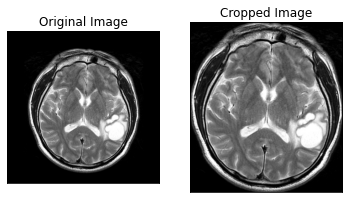

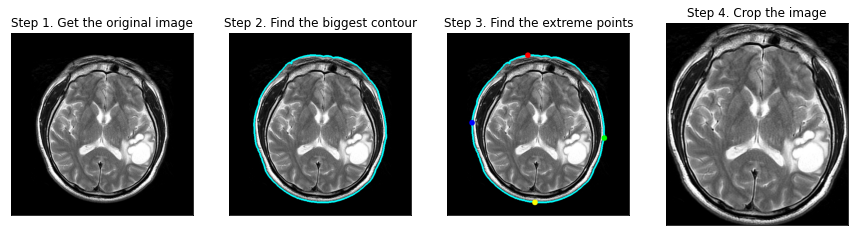

In [79]:
exam_img = cv2.imread('C:\\Users\\rahul\\CNN MODEL\\brain_tumor_dataset\\yes\\Y90.jpg')
exam_new_img = crop_brain_contour(exam_img, True)

### Data augmentation

About the data: Since the dataset we are using contains 253 images which include 155 brain MRI images are tumorous(61% of the total data) and 98 are non-tumorous. 

Since their is a data imbalance, use of data augmentation comes handy to generate new synthetic images out from the exsisting data by using means like rotation, contrast etc.


In [10]:
from keras.preprocessing.image import ImageDataGenerator
import time
from os import listdir

In [11]:
# Function for nicely formatted time string

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [18]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir:                A string representing the directory where images that we want to augment are found.
        n_generated_samples:     A string representing the number of generated samples using the given image.
        save_to_dir:             A string representing the directory in which the generated images will be saved.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

Remember that 61% of the data (155 images) are tumorous. And, 39% of the data (98 images) are non-tumorous.
So, in order to balance the data we can generate 9 new images for every image that belongs to 'no' class and 6 images for every image that belongs the 'yes' class.

In [19]:
start_time = time.time()

augmented_data_path = 'C:\\Users\\rahul\\CNN MODEL\\brain_tumor_dataset\\augmented data\\'
yes_path = 'C:\\Users\\rahul\\CNN MODEL\\brain_tumor_dataset\\yes'
no_path = 'C:\\Users\\rahul\\CNN MODEL\\brain_tumor_dataset\\no'

# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")    #time taken to generate the augmented images

Elapsed time: 0:2:5.4


In [20]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")

In [21]:
data_summary(augmented_data_path)   #percentage of images generated

Number of examples: 2064
Percentage of positive examples: 52.56782945736434%, number of pos examples: 1085
Percentage of negative examples: 47.43217054263566%, number of neg examples: 979


## Loading images to resize and normalize and create a numpy array

Load up the data:
The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

Read the image.
Crop the part of the image representing only the brain.
Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
Apply normalization because we want pixel values to be scaled to the range 0-1.
Append the image to X and its label to y.
After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

In [22]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [23]:
augmented_data_path

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_data_path + 'yes' 
augmented_no = augmented_data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


## Plotting of the augmented images

In [24]:
def plot_sample_images(X, y, n=50):
    """
    Plot n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

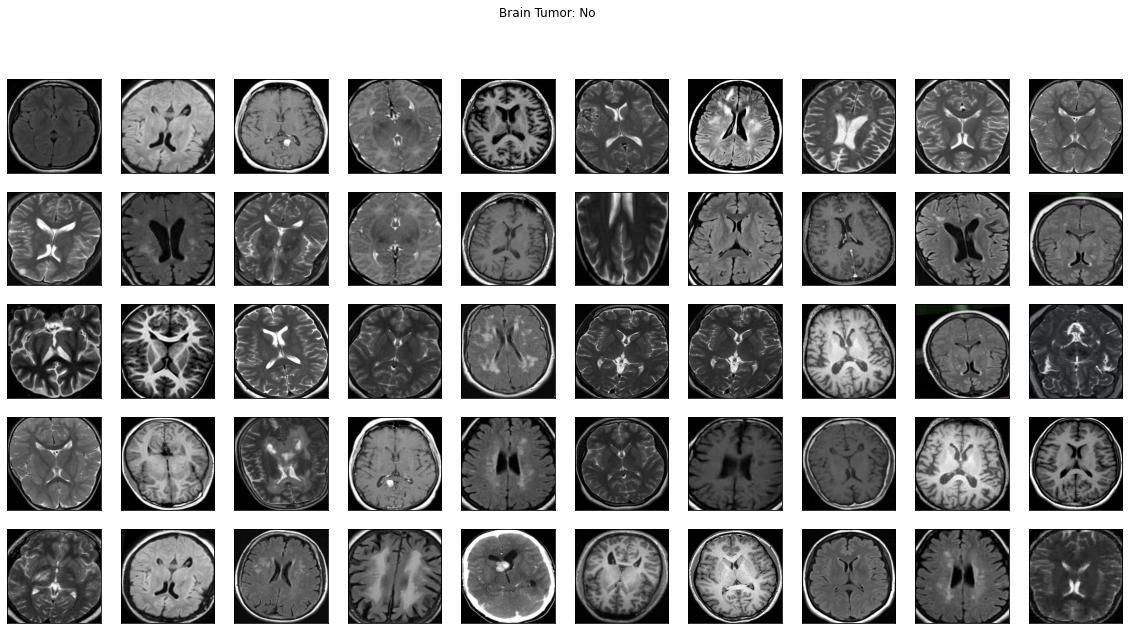

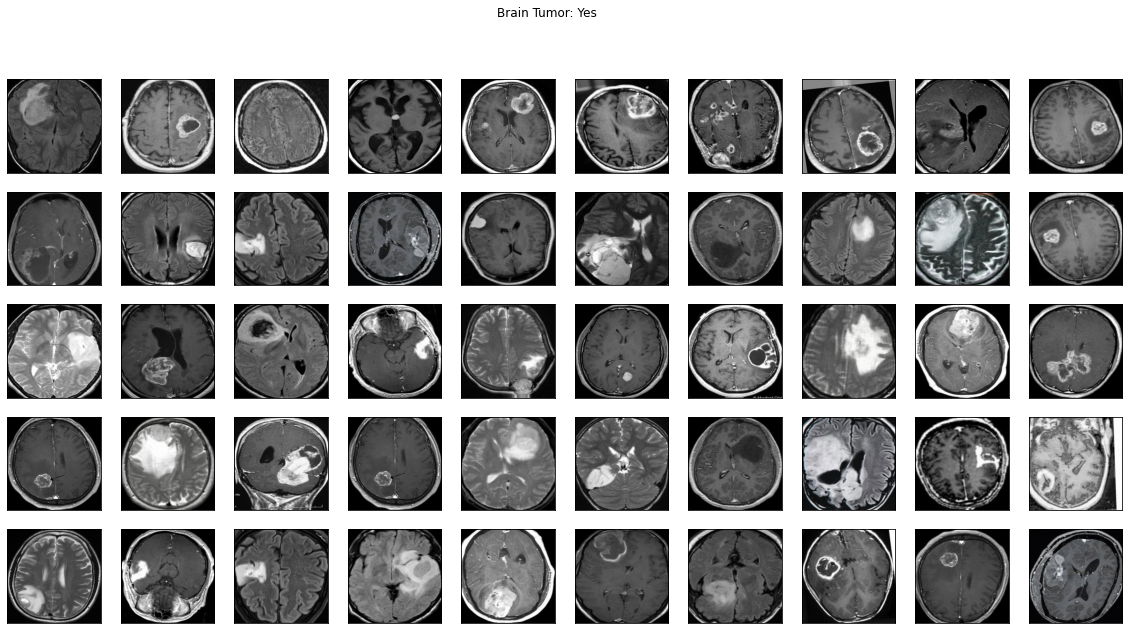

In [25]:
plot_sample_images(X, y)

## Splitting the dataset into training, development(validation) and test sets

In [26]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)  
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [27]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)


Let's use the following way to split:

70% of the data for training.
15% of the data for validation.
15% of the data for testing.

In [28]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1444
number of development examples = 310
number of test examples = 310
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [29]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [30]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

## Building the Model

In [73]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [74]:
#model summary containing the shape and parameters of each layer
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

model = build_model(IMG_SHAPE)

model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [75]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [76]:
# saving log files and tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')


In [77]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))


Checking the epochs needed to maxmize the model's prediction

In [36]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - 133s 2s/step - loss: 0.7601 - accuracy: 0.6454 - val_loss: 0.6699 - val_accuracy: 0.5613
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.56.model\assets
Epoch 2/10
46/46 [==============================] - 93s 2s/step - loss: 0.4577 - accuracy: 0.7895 - val_loss: 0.6004 - val_accuracy: 0.7323
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.73.model\assets
Epoch 3/10
46/46 [==============================] - 91s 2s/step - loss: 0.4215 - accuracy: 0.8068 - val_loss: 0.5541 - val_accuracy: 0.7484
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.75.model\assets
Epoch 4/10
46/46 [==============================] - 96s 2s/step - loss: 0.3651 - accuracy: 0.8352 - val_loss: 0.5197 - val_accuracy: 0.7871
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.79.model\assets
Epoch 5/10
46/46 [==============================] - 92s 2s/step - loss: 0.3607 

In [37]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 93s 2s/step - loss: 0.3336 - accuracy: 0.8456 - val_loss: 1.2376 - val_accuracy: 0.5968
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.60.model\assets
Epoch 2/3
46/46 [==============================] - 91s 2s/step - loss: 0.2071 - accuracy: 0.9169 - val_loss: 0.4868 - val_accuracy: 0.8194
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.82.model\assets
Epoch 3/3
46/46 [==============================] - 113s 2s/step - loss: 0.1865 - accuracy: 0.9231 - val_loss: 0.6231 - val_accuracy: 0.7516
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.75.model\assets
Elapsed time: 0:5:7.2


In [38]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 98s 2s/step - loss: 0.2077 - accuracy: 0.9190 - val_loss: 0.4076 - val_accuracy: 0.8452
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.85.model\assets
Epoch 2/3
46/46 [==============================] - 94s 2s/step - loss: 0.2070 - accuracy: 0.9245 - val_loss: 0.3848 - val_accuracy: 0.8387
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.84.model\assets
Epoch 3/3
46/46 [==============================] - 93s 2s/step - loss: 0.2971 - accuracy: 0.8684 - val_loss: 0.4270 - val_accuracy: 0.8581
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.86.model\assets
Elapsed time: 0:4:52.3


In [39]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - 95s 2s/step - loss: 0.1344 - accuracy: 0.9529 - val_loss: 0.4296 - val_accuracy: 0.8452
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.85.model\assets
Epoch 2/3
46/46 [==============================] - 93s 2s/step - loss: 0.1249 - accuracy: 0.9619 - val_loss: 0.3978 - val_accuracy: 0.8677
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.87.model\assets
Epoch 3/3
46/46 [==============================] - 94s 2s/step - loss: 0.1362 - accuracy: 0.9557 - val_loss: 0.7654 - val_accuracy: 0.6968
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.70.model\assets
Elapsed time: 0:4:48.8


In [40]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/5
46/46 [==============================] - 97s 2s/step - loss: 0.1292 - accuracy: 0.9591 - val_loss: 0.5604 - val_accuracy: 0.8000
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.80.model\assets
Epoch 2/5
46/46 [==============================] - 93s 2s/step - loss: 0.1000 - accuracy: 0.9716 - val_loss: 0.4051 - val_accuracy: 0.8774
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.88.model\assets
Epoch 3/5
46/46 [==============================] - 93s 2s/step - loss: 0.1132 - accuracy: 0.9661 - val_loss: 0.3766 - val_accuracy: 0.8677
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets
Epoch 4/5
46/46 [==============================] - 96s 2s/step - loss: 0.0925 - accuracy: 0.9771 - val_loss: 0.4214 - val_accuracy: 0.8548
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.85.model\assets
Epoch 5/5
46/46 [==============================] - 92s 2s/step - loss: 0.0950 - accu

In [100]:
"After 22-24 epochs the train and development accuracies are showing better numbers.Now train for 25 epochs executing the model again "

In [78]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/25
46/46 [==============================] - 117s 2s/step - loss: 0.8853 - accuracy: 0.6011 - val_loss: 0.6480 - val_accuracy: 0.6290
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets
Epoch 2/25
46/46 [==============================] - 100s 2s/step - loss: 0.4594 - accuracy: 0.7819 - val_loss: 0.6081 - val_accuracy: 0.6774
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.68.model\assets
Epoch 3/25
46/46 [==============================] - 100s 2s/step - loss: 0.4190 - accuracy: 0.8144 - val_loss: 0.5653 - val_accuracy: 0.7419
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.74.model\assets
Epoch 4/25
46/46 [==============================] - 117s 3s/step - loss: 0.3735 - accuracy: 0.8352 - val_loss: 0.5177 - val_accuracy: 0.7677
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.77.model\assets
Epoch 5/25
46/46 [==============================] - 97s 2s/step - loss: 0.32

In [81]:
history = model.history.history

In [82]:
for key in history.keys():
    print(key)         

loss
accuracy
val_loss
val_accuracy


## Ploting the graphs

In [83]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_accuracy = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

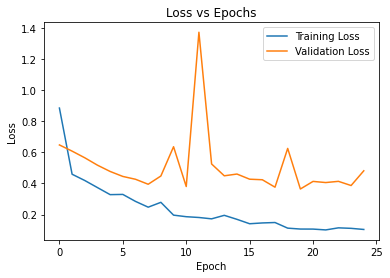

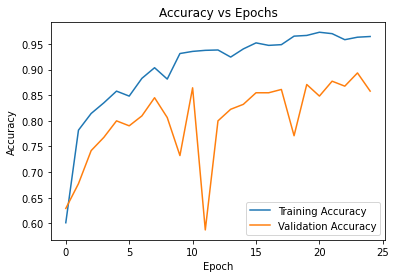

In [84]:
plot_metrics(history)

In [110]:
%load_ext tensorboard
%tensorboard --logdir logs/brain_tumor_detection_cnn_1637042220

Reusing TensorBoard on port 6006 (pid 2316), started 0:13:32 ago. (Use '!kill 2316' to kill it.)

In [ ]:
"From the results we can identify the best model performace at 23rd epoch with validation accuracy= 86.77 "

In [101]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.87.model')

In [102]:
best_model.metrics_names

['loss', 'accuracy']

In [103]:
#Evaluate the best model on the testing data:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 5s 491ms/step - loss: 0.3322 - accuracy: 0.9065


## Accuracy of the best model on the testing data:

In [104]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.33219218254089355
Test Accuracy = 0.9064516425132751


In [105]:
y_test_prob = best_model.predict(X_test)


## F1 score for the best model on the testing data:

In [106]:

f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9090909090909091


In [107]:
y_val_prob = best_model.predict(X_val)

In [108]:
#Let's also find the f1 score on the validation data:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8690095846645367


## Conclusion:

### Now, the model detects brain tumor with:

**0.91%** accuracy on the **test set**.

**0.91** f1 score on the **test set**.